In [132]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [133]:
def generate_cloud_events(n = 5000, noise = 0.05):
    identity_mismatch = np.random.binomial(1, 0.1, n)
    unusual_time = np.random.binomial(1, 0.15, n)
    region_risk = np.random.beta(2, 5, n)
    key_sensitivity = np.random.uniform(0.2, 1.0, n)
    request_frequency = np.random.poisson(3, n)

    fraud_score = (
        (2.5 * identity_mismatch) +
        (1.5 * unusual_time) +
        (3.0 * region_risk) +
        (1.8 * key_sensitivity) +
        (0.2 * request_frequency) +
        np.random.normal(0, noise, n)
    )

    fraud_prob = 1 / (1 + np.exp(-fraud_score))
    fraud = np.random.binomial(1, fraud_prob)

    return pd.DataFrame({
        "identity_mismatch": identity_mismatch,
        "unusual_time": unusual_time,
        "region_risk": region_risk,
        "key_sensitivity": key_sensitivity,
        "request_frequency": request_frequency,
        "fraud": fraud
    })

In [134]:
df = generate_cloud_events()
df.head()

,identity_mismatch,unusual_time,region_risk,key_sensitivity,request_frequency,fraud
0,0,0,0.040154,0.208992,3,1
1,0,1,0.151454,0.211615,1,1
2,0,0,0.403491,0.322780,1,1
3,0,0,0.095597,0.647930,4,1
4,0,0,0.175740,0.422023,3,1


In [135]:
df.describe()

,identity_mismatch,unusual_time,region_risk,key_sensitivity,request_frequency,fraud
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,0.096800,0.137800,0.287122,0.601201,3.001400,0.92020
std,0.295715,0.344724,0.159457,0.232555,1.724991,0.27101
min,0.000000,0.000000,0.002215,0.200092,0.000000,0.00000
25%,0.000000,0.000000,0.164151,0.402393,2.000000,1.00000
50%,0.000000,0.000000,0.265278,0.598832,3.000000,1.00000
75%,0.000000,0.000000,0.393535,0.807248,4.000000,1.00000
max,1.000000,1.000000,0.837847,0.999636,11.000000,1.00000


In [136]:
def prepare_data(df):
    X = df.drop("fraud", axis = 1)
    y = df["fraud"].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

X, y, scaler = prepare_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [137]:
def build_model(input_dim, hidden_units = [128, 64, 32], dropout = 0.3, learning_rate = 0.001):
    model = models.Sequential()
    model.add(layers.Input(shape = (input_dim,)))
    for units in hidden_units:
        model.add(layers.Dense(units, activation = "relu"))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation = "sigmoid"))
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate),
        loss = "binary_crossentropy",
        metrics = ["accuracy",
            tf.keras.metrics.AUC(name = "auc"),
            tf.keras.metrics.Precision(name = "precision"),
            tf.keras.metrics.Recall(name = "recall")
        ]
    )
    return model

In [138]:
model = build_model(X.shape[1])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               768       
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                

In [139]:
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    epochs = 25,
    batch_size = 64,
    callbacks = [EarlyStopping(patience = 5, restore_best_weights = True), ReduceLROnPlateau(patience = 3, factor = 0.5)],
    verbose = 1
)

Epoch 1/25
50/50 [==============================] - 2s 11ms/step - loss: 0.3542 - accuracy: 0.9056 - auc: 0.5661 - precision: 0.9190 - recall: 0.9840 - val_loss: 0.2594 - val_accuracy: 0.9262 - val_auc: 0.6376 - val_precision: 0.9262 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/25
50/50 [==============================] - 0s 3ms/step - loss: 0.2800 - accuracy: 0.9187 - auc: 0.6704 - precision: 0.9187 - recall: 1.0000 - val_loss: 0.2608 - val_accuracy: 0.9262 - val_auc: 0.6546 - val_precision: 0.9262 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/25
50/50 [==============================] - 0s 3ms/step - loss: 0.2765 - accuracy: 0.9187 - auc: 0.6913 - precision: 0.9187 - recall: 1.0000 - val_loss: 0.2604 - val_accuracy: 0.9262 - val_auc: 0.6627 - val_precision: 0.9262 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/25
50/50 [==============================] - 0s 3ms/step - loss: 0.2735 - accuracy: 0.9187 - auc: 0.6889 - precision: 0.9187 - recall: 1.0000 - val_loss: 0.2570 - val_accuracy: 0.9262 - val_a

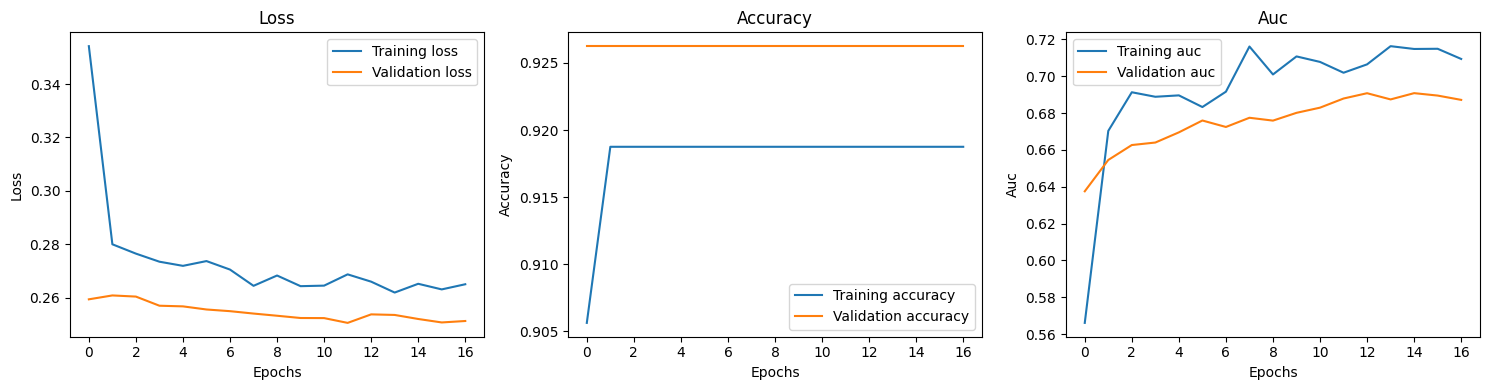

In [140]:
def plot_training(history):
    metrics = ["loss", "accuracy", "auc"]
    plt.figure(figsize = (15,4))
    for i, m in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(history.history[m], label = f"Training {m}")
        plt.plot(history.history[f"val_{m}"], label = f"Validation {m}")
        plt.xlabel("Epochs")
        plt.ylabel(m.capitalize())
        plt.legend()
        plt.title(m.capitalize())
    plt.tight_layout()
    plt.show()

plot_training(history)

In [141]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob)}\n")
print(classification_report(y_test, y_pred))

32/32 [==============================] - 0s 902us/step
ROC AUC: 0.7472418478260869

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.92      1.00      0.96       920

    accuracy                           0.92      1000
   macro avg       0.46      0.50      0.48      1000
weighted avg       0.85      0.92      0.88      1000



c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [142]:
def predict_event(event, scaler, model):
    df_event = pd.DataFrame([event])
    X_scaled = scaler.transform(df_event)
    return float(model.predict(X_scaled)[0][0])

sample_event = {
    "identity_mismatch": 1,
    "unusual_time": 1,
    "region_risk": 0.85,
    "key_sensitivity": 0.9,
    "request_frequency": 12
}

print("Fraud Probability:", predict_event(sample_event, scaler, model))

1/1 [==============================] - 0s 20ms/step
Fraud Probability: 0.9999380707740784


In [143]:
# Model Evaluation
print(model.evaluate(X_test, y_test))

32/32 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.9200 - auc: 0.7484 - precision: 0.9200 - recall: 1.0000
[0.2487056851387024, 0.9200000166893005, 0.7484443187713623, 0.9200000166893005, 1.0]


In [144]:
# Model Export/Deployment
model.save("kc_ids_model.keras")
joblib.dump(scaler, "feature_scaler.joblib")

['feature_scaler.joblib']